In [0]:
import pickle
import gzip
import numpy as np
import random
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
def load_data():
    f = gzip.open('/content/drive/My Drive/Colab Notebooks/ECE 559 - Neural Networks/HW5/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data =pickle.load(f, encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    e = np.zeros((10, 1))  
    e[j] = 1.0
    return e

In [0]:
class QuadraticCost(object):
  @staticmethod
  def fn(a, y):
    return 0.5*np.linalg.norm(a-y)**2

  @staticmethod
  def delta(z, a, y):
    return (a-y) * sigmoid_prime(z)

In [0]:
class CrossEntropyCost(object):
  @staticmethod
  def fn(a, y):
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

  @staticmethod
  def delta(z, a, y):
    return (a-y)

In [0]:
class Network(object):
  def __init__(self, sizes,cost = CrossEntropyCost ):
    self.num_layers = len(sizes)    
    self.sizes = sizes
    self.cost=cost
    self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
    self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]

  def feedforward(self, a):
    for b, w in zip(self.biases, self.weights):
      a = sigmoid(np.dot(w, a)+b)
    return a

  def SGD(self, training_data, epochs, mini_batch_size, eta,lmbda = 0.0,test_data=None,monitor_test_cost=False,
            monitor_test_accuracy=False,
            monitor_training_cost=False,
            monitor_training_accuracy=False):
   
    if test_data: n_data = len(test_data)
    n = len(training_data)
    test_cost, test_accuracy = [], []
    training_cost, training_accuracy = [], []
    for j in range(epochs):
      random.shuffle(training_data)
      mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
      for mini_batch in mini_batches:
        self.update_mini_batch(mini_batch, eta ,lmbda,len(training_data))
      print ("Epoch %s training complete" % j)
      if monitor_training_cost:
        cost = self.total_cost(training_data, lmbda)
        training_cost.append(cost)
        print ("Cost on training data: {}".format(cost))
      if monitor_training_accuracy:
        accuracy = self.accuracy(training_data, convert=True)
        training_accuracy.append(accuracy)
        print ("Accuracy on training data: {} / {}".format(accuracy, n))
      if monitor_test_cost:
        cost = self.total_cost(test_data, lmbda, convert=True)
        test_cost.append(cost)
        print ("Cost on test data: {}".format(cost))
      if monitor_test_accuracy:
        accuracy = self.accuracy(test_data)
        test_accuracy.append(accuracy)
        print ("Accuracy on test data: {} / {}".format(self.accuracy(test_data), n_data))
    
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(test_cost,c = 'green', label='Testing Cost')
    plt.plot(training_cost,c = 'blue', label='Training Cost')
    plt.xlabel("epochs")
    plt.ylabel("Cost")
    plt.legend(loc = 'best')
    plt.show()
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(np.array(test_accuracy)/n_data ,c = 'green', label='Testing accuracy')
    plt.plot(np.array(training_accuracy)/n,c = 'blue', label='Training accuracy')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc = 'best')
    plt.show()
    fig, ax = plt.subplots(figsize=(10,10))
    plt.plot(n_data-np.array(test_accuracy) ,c = 'green', label='Testing misclassification')
    plt.plot(n-np.array(training_accuracy),c = 'blue', label='Training misclassification')
    plt.xlabel("epochs")
    plt.ylabel("Misclassification")
    plt.legend(loc = 'best')
    plt.show()
    return test_cost, test_accuracy, \
            training_cost, training_accuracy

  def update_mini_batch(self, mini_batch, eta,lmbda, n):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    for x, y in mini_batch:
      delta_nabla_b, delta_nabla_w = self.backprop(x, y)
      nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
      nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
      self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
      self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
    
  def backprop(self, x, y):
    nabla_b = [np.zeros(b.shape) for b in self.biases]
    nabla_w = [np.zeros(w.shape) for w in self.weights]
    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(self.biases, self.weights):
      z = np.dot(w, activation)+b
      zs.append(z)
      activation = sigmoid(z)
      activations.append(activation)
    delta = (self.cost).delta(zs[-1], activations[-1], y)
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())
    for l in range(2, self.num_layers):
      z = zs[-l]
      sp = sigmoid_prime(z)
      delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
      nabla_b[-l] = delta
      nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
    return (nabla_b, nabla_w)

  def evaluate(self, test_data):
    test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
    return sum(int(x == y) for (x, y) in test_results)

  def accuracy(self, data, convert=False):
    if convert:
      results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
    else:
      results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
    return sum(int(x == y) for (x, y) in results)
    
  def total_cost(self, data, lmbda, convert=False):
    cost = 0.0
    for x, y in data:
      a = self.feedforward(x)
      if convert: y = vectorized_result(y)
      cost += self.cost.fn(a, y)/len(data)
    cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
    return cost

  def cost_derivative(self, output_activations, y):
    return (output_activations-y)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [0]:
training_data, validation_data, test_data =load_data_wrapper()

In [0]:
training_data=list(training_data)
validation_data=list(validation_data)
test_data=list(test_data)

Epoch 0 training complete
Cost on training data: 0.5977429263353846
Accuracy on training data: 45999 / 50000
Cost on test data: 0.9345852467242933
Accuracy on test data: 9207 / 10000
Epoch 1 training complete
Cost on training data: 0.48279337095694963
Accuracy on training data: 47032 / 50000
Cost on test data: 0.8325179027766685
Accuracy on test data: 9363 / 10000
Epoch 2 training complete
Cost on training data: 0.4245080404286664
Accuracy on training data: 47363 / 50000
Cost on test data: 0.7976200218087479
Accuracy on test data: 9405 / 10000
Epoch 3 training complete
Cost on training data: 0.447067768421489
Accuracy on training data: 47215 / 50000
Cost on test data: 0.8312907183786955
Accuracy on test data: 9354 / 10000
Epoch 4 training complete
Cost on training data: 0.33736763878996656
Accuracy on training data: 48043 / 50000
Cost on test data: 0.7408283280382159
Accuracy on test data: 9453 / 10000
Epoch 5 training complete
Cost on training data: 0.28254142905371504
Accuracy on tra

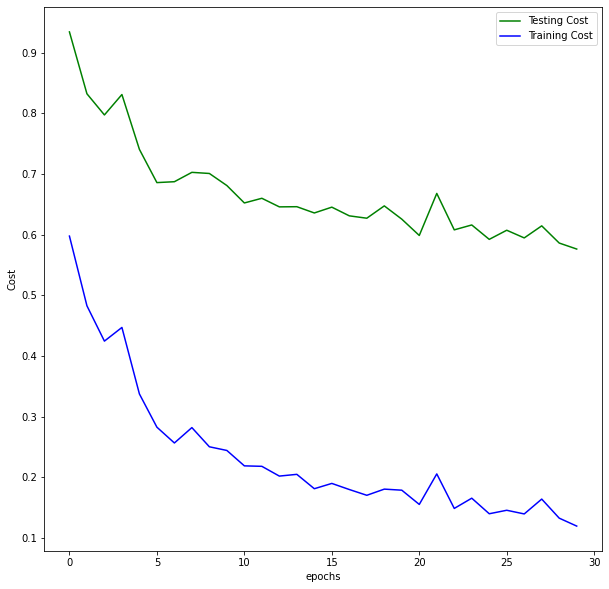

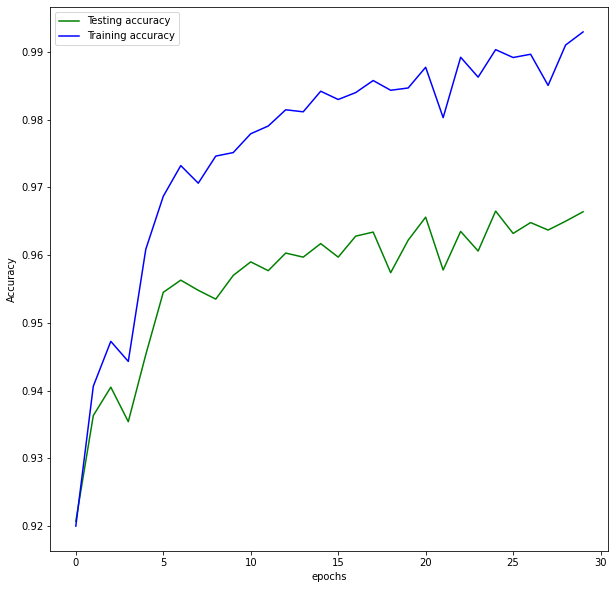

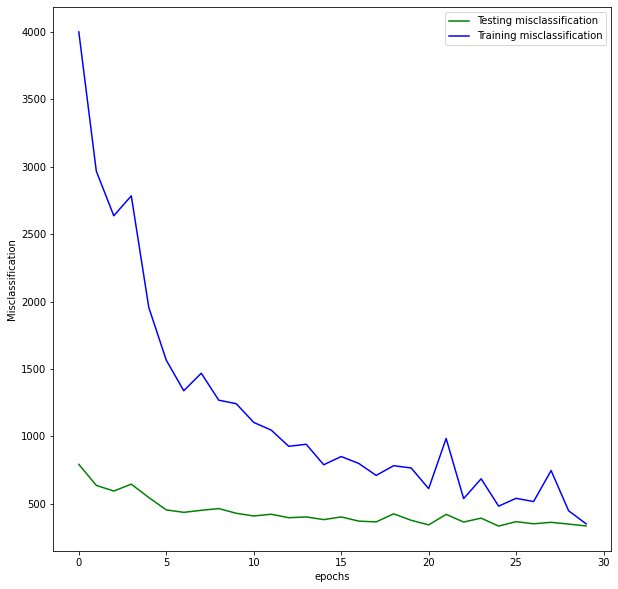

([0.9345852467242933,
  0.8325179027766685,
  0.7976200218087479,
  0.8312907183786955,
  0.7408283280382159,
  0.6859953799207519,
  0.6874687908616817,
  0.7029160350900218,
  0.7010570773934639,
  0.6811410847478829,
  0.6524181179189634,
  0.660136394434448,
  0.6459632235997415,
  0.6462499802352057,
  0.6359215549558427,
  0.6454941554064204,
  0.6311599680247211,
  0.6272528377213505,
  0.647580453214759,
  0.6256956327340866,
  0.5987957050523882,
  0.6681447616853383,
  0.6080322341039135,
  0.6161242867102237,
  0.5923685123563912,
  0.6074161026659373,
  0.5947563278586578,
  0.6146523693993815,
  0.5862866113800088,
  0.5763952522766989],
 [9207,
  9363,
  9405,
  9354,
  9453,
  9545,
  9563,
  9548,
  9535,
  9570,
  9590,
  9577,
  9603,
  9597,
  9617,
  9597,
  9628,
  9634,
  9574,
  9622,
  9656,
  9578,
  9635,
  9606,
  9665,
  9632,
  9648,
  9637,
  9650,
  9664],
 [0.5977429263353846,
  0.48279337095694963,
  0.4245080404286664,
  0.447067768421489,
  0.33736763

In [0]:
net =Network([784, 100,40, 10] ,cost= CrossEntropyCost)
net.SGD(training_data, 30 , 10 ,0.1 ,lmbda = 0.1, test_data=test_data,monitor_test_accuracy=True,monitor_test_cost=True,monitor_training_accuracy=True,monitor_training_cost=True)